In [1]:
%%time
import bayes3d as b
import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm
import bayes3d.o3d_viz
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
CPU times: user 5.83 s, sys: 2.04 s, total: 7.87 s
Wall time: 5.18 s


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [62]:
original_intrinsics = b.Intrinsics(
    height=500,
    width=500,
    fx=500.0, fy=500.0,
    cx=250.0, cy=250.0,
    near=0.001, far=6.0
)

renderer = b.Renderer(original_intrinsics)
renderer.add_mesh(b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.1])))
renderer.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/sphere.obj"),scaling_factor=1.0/10.0)
renderer.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/pyramid.obj"),scaling_factor=1.0/10.0)
renderer.add_mesh(b.mesh.make_cuboid_mesh(jnp.array([0.7, 0.7, 0.02])))
table_mesh = b.mesh.make_cuboid_mesh(jnp.array([5.0, 5.0, 0.01]))

Increasing frame buffer size to (width, height, depth) = (512, 512, 512)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [63]:
viz = b.o3d_viz.O3DVis(original_intrinsics)

In [ ]:
contact_plane = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 1.5, 0.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
))


contact_poses_parallel_jit = jax.jit(
    jax.vmap(
        b.scene_graph.relative_pose_from_edge,
        in_axes=(0, None, 0),
    )
)
contact_poses_jit = jax.jit(
    jax.vmap(
        b.scene_graph.relative_pose_from_edge,
        in_axes=(0, None, None),
    )
)

# TODO: 4 different distinguishable colors
# TODO: colored pad (make it an object)
# Top down containment
# TODO: Different shapes

distinct_colors = b.distinct_colors(4)
ids = jnp.array([0, 1, 2, 2, 3])
color = jnp.array([0, 0, 1, 1, 0])
contact_params = jnp.array([
    [-0.2, -0.2, 0.0],
    [0.3, -0.3, 0.0],
    [0.25, 0.2, 0.0],
    [0.4, 0.1, 0.0],
    [0.5, -0.1, 0.0],
])
poses = contact_plane @ contact_poses_parallel_jit(
    contact_params,
    3,
    renderer.model_box_dims[ids]
)
viz.clear()

viz.make_trimesh(table_mesh, contact_plane, np.array([221, 174, 126, 255.0])/255.0)
for i in range(len(poses)):
    viz.make_trimesh(renderer.meshes[ids[i]], poses[i], np.array([*distinct_colors[color[i]], 1.0]))
    
rgbd = viz.capture_image(original_intrinsics, jnp.eye(4))
np.savez("rgbd.npz",rgbd)
b.get_rgb_image(rgbd.rgb)


In [51]:
rgbd_original = np.load("rgbd.npz",allow_pickle=True)["arr_0"].item()
SCALING_FACTOR = 0.4
rgbd = b.scale_rgbd(rgbd_original, SCALING_FACTOR)

In [52]:
intrinsics = rgbd.intrinsics
observed_point_cloud_image = b.t3d.unproject_depth(rgbd.depth, intrinsics)[:,:,:3]
observed_point_cloud_image = (
    observed_point_cloud_image *
    (b.t3d.apply_transform(observed_point_cloud_image, b.t3d.inverse_pose(contact_plane))[:,:,2]>0.02)[...,None]
)
observed_point_cloud_image = b.t3d.unproject_depth(observed_point_cloud_image[:,:,2], intrinsics)
b.clear()
b.show_cloud("1", observed_point_cloud_image[:,:,:3].reshape(-1,3))

In [53]:
# observed_point_cloud_image = renderer.render_multiobject(poses, [0 for _ in range(len(poses))])[:,:,:3]
# b.clear()
# b.show_cloud("1", observed_point_cloud_image[:,:,:3].reshape(-1,3))
# b.get_depth_image(observed_point_cloud_image[:,:,2])


In [57]:
grid_params = [
    (0.6, jnp.pi, (11,11,11)), (0.6, jnp.pi/3, (11,11,11)), (0.4, jnp.pi/5, (11,11,1)),
    (0.0, jnp.pi/2, (1,1,11*11)), (0.2, jnp.pi/5, (11,11,11)), 
    (0.1, 0.0, (16,16,1)),
    (0.0, jnp.pi/10, (1,1,11*11)),
    (0.05, 0.0, (16,16,1)),
    (0.0, jnp.pi/20, (1,1,11*11)),
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

renderer = b.Renderer(intrinsics)
cube = b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.1]))
renderer.add_mesh(cube)
renderer.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/sphere.obj"),scaling_factor=1.0/10.0)
renderer.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/pyramid.obj"),scaling_factor=1.0/10.0)

Increasing frame buffer size to (width, height, depth) = (224, 224, 512)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [58]:
# trace = Trace(
#     plane_pose[None,...], [21],
#     VARIANCE, 0.01,
#     observed_point_cloud_image
# )
VARIANCE_GRID = jnp.array([0.00001])
OUTLIER_GRID = jnp.array([ 0.001])
gt_trace = b.Trace(
    poses, [0 for _ in range(len(poses))], VARIANCE_GRID[0], OUTLIER_GRID[0], 1e-20,
    observed_point_cloud_image
)
b.show_cloud("rerender", b.render_image(gt_trace, renderer)[:,:,:3].reshape(-1,3),color=b.RED)

trace = b.Trace(
    jnp.zeros((0,4,4)), [],
    VARIANCE_GRID[0], OUTLIER_GRID[0], 0.1,
    observed_point_cloud_image
)
b.viz_trace_meshcat(trace, renderer)

In [59]:
for _ in range(10):
    all_traces = []
    for obj_id in tqdm(range(len(renderer.meshes))):
        contact_param = jnp.zeros(3)
        p = None
        traces = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = contact_plane @ contact_poses_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
            )

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )

            traces = b.Traces(
                potential_poses, trace.ids + [obj_id], VARIANCE_GRID, OUTLIER_GRID,
                trace.outlier_volume, trace.observation
            )
            p = b.score_traces(traces, renderer)      

            ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]

        best_trace = b.Trace(
            traces.all_poses[:,ii], traces.ids, traces.all_variances[jj],
            traces.all_outlier_prob[kk], traces.outlier_volume,
            traces.observation
        )

        all_traces.append(
            best_trace
        )


    scores = jnp.array([b.score_trace(t, renderer) for t in all_traces])
    normalized_scores = b.utils.normalize_log_scores(scores)
    print(["{:0.3f}".format(n) for n in normalized_scores])
    order = jnp.argsort(-scores)
    print(order)

    
    prev_score = b.score_trace(trace, renderer)
    new_trace = all_traces[jnp.argmax(scores)]
    print(new_trace.ids)
    new_score = b.score_trace(new_trace, renderer)
    score_delta = new_score - prev_score
    print(score_delta)
    if score_delta < 10.0:
        print("Done parsing")
        break
    
    trace = new_trace
    b.viz_trace_meshcat(trace, renderer)

    
# b.viz_trace_meshcat(new_trace, renderer)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


['0.000', '1.000', '0.000']
[1 2 0]
[1]
49338.0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


['0.000', '0.000', '1.000']
[2 0 1]
[1, 2]
44738.0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


['1.000', '0.000', '0.000']
[0 1 2]
[1, 2, 0]
43915.0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


['0.000', '1.000', '0.000']
[1 0 2]
[1, 2, 0, 1]
43285.0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


['0.000', '0.000', '1.000']
[2 0 1]
[1, 2, 0, 1, 2]
33921.0


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]

['0.368', '0.368', '0.368']
[0 1 2]
[1, 2, 0, 1, 2, 0]
0.0
Done parsing


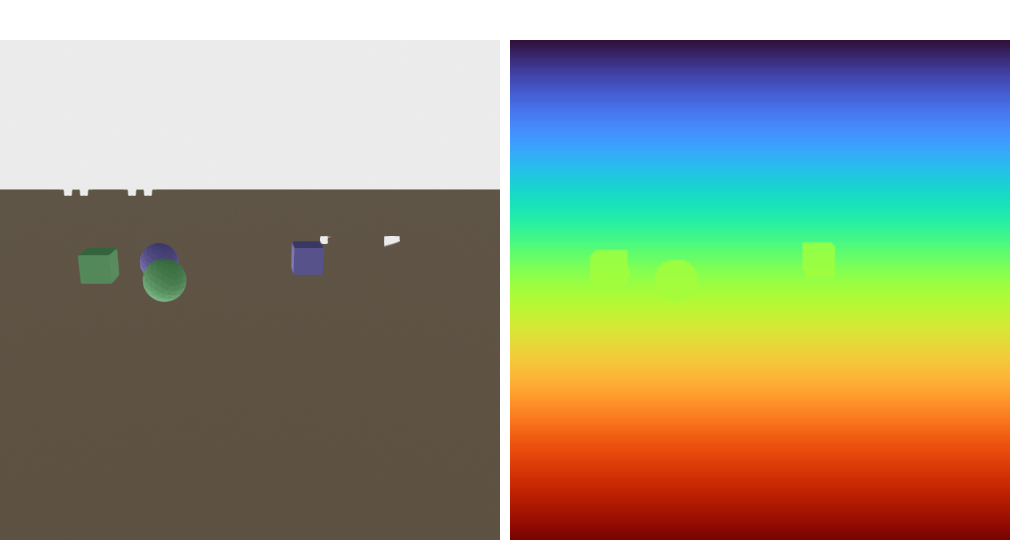

In [27]:
inferred = b.render_image(trace, renderer)[:,:,:2]
b.multi_panel(
    [
        b.get_rgb_image(rgbd_original.rgb),
        b.scale_image(b.get_depth_image(inferred[:,:,2]),1/SCALING_FACTOR)
    ]
)

In [51]:
b.score_trace(gt_trace, renderer, filter_size=i)

Array(1565758., dtype=float32)

In [53]:
x = b.render_image(gt_trace, renderer)[:,:,:3]
b.clear()
b.show_cloud("1", x.reshape(-1,3))

0
39.143948
1
39.143948
2
39.143948
3
39.143948
4
39.143948
5
39.143948


[15 14]


Array([[4.21553057e-31, 2.49202155e-21, 1.81754445e-15, 1.63620419e-13,
        1.81767426e-15, 2.49202155e-21, 4.21643100e-31],
       [2.49113297e-21, 1.47263955e-11, 1.07406295e-05, 9.66901367e-04,
        1.07413971e-05, 1.47263955e-11, 2.49166531e-21],
       [1.81728611e-15, 1.07429332e-05, 7.83530903e+00, 7.05356323e+02,
        7.83586931e+00, 1.07429332e-05, 1.81767426e-15],
       [1.63585481e-13, 9.67039727e-04, 7.05305969e+02, 6.34936094e+04,
        7.05356323e+02, 9.67039727e-04, 1.63620419e-13],
       [1.81728611e-15, 1.07429332e-05, 7.83530903e+00, 7.05356323e+02,
        7.83586931e+00, 1.07429332e-05, 1.81767426e-15],
       [2.49148921e-21, 1.47285031e-11, 1.07421656e-05, 9.67039727e-04,
        1.07429332e-05, 1.47285031e-11, 2.49202155e-21],
       [4.21553057e-31, 2.49202155e-21, 1.81754445e-15, 1.63620419e-13,
        1.81767426e-15, 2.49202155e-21, 4.21643100e-31]], dtype=float32)

Array([[[2.6608486, 2.6608543, 3.9894223],
        [3.332247 , 2.6608543, 3.9894223],
        [3.8138752, 2.6608543, 3.9894223],
        [3.9894223, 2.6608543, 3.9894223],
        [3.813878 , 2.6608543, 3.9894223],
        [3.332247 , 2.6608543, 3.9894223],
        [2.6608543, 2.6608543, 3.9894223]],

       [[2.6608486, 3.3322425, 3.9894223],
        [3.332247 , 3.3322425, 3.9894223],
        [3.8138752, 3.3322425, 3.9894223],
        [3.9894223, 3.3322425, 3.9894223],
        [3.813878 , 3.3322425, 3.9894223],
        [3.332247 , 3.3322425, 3.9894223],
        [2.6608543, 3.3322425, 3.9894223]],

       [[2.6608486, 3.813878 , 3.9894223],
        [3.332247 , 3.813878 , 3.9894223],
        [3.8138752, 3.813878 , 3.9894223],
        [3.9894223, 3.813878 , 3.9894223],
        [3.813878 , 3.813878 , 3.9894223],
        [3.332247 , 3.813878 , 3.9894223],
        [2.6608543, 3.813878 , 3.9894223]],

       [[2.6608486, 3.9894223, 3.9894223],
        [3.332247 , 3.9894223, 3.9894223],
     

In [ ]:
# object_types: cube, sphere, pyramid, pad
# Output
# List of (object_type, color, contact_params)